### L_30 Color and Gradient

#### My Solution:

In [1]:
%matplotlib inline

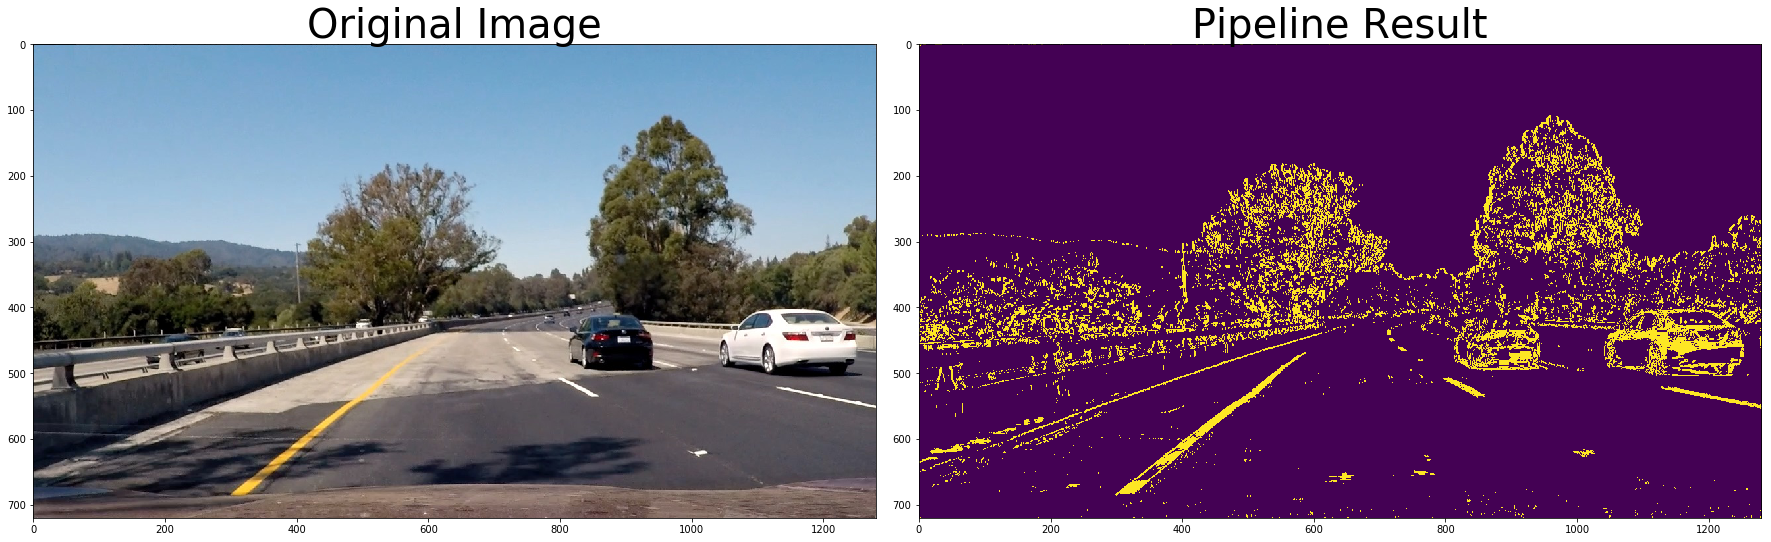

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('bridge_shadow.jpg')


# Edit this function to create your own pipeline.
 
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
# def pipeline(orig_image, s_thresh=(170, 255), sx_thresh=(20, 100)):

    #     ## !! LINE BELOW :: HOW DOES DEEP COPYING TO ITSELF HELP ??!!
    #     ## WHAT AM I MISSING HERE ?
    #     img = np.copy(img)
    #
    #     # SHOULD IT NOT BE: ??
    #     img_copy = np.copy(img) 
    #
    #     # IN Fact, does Not Python Pass by COPY Always ??
    #     # So np.copy() is NOT Needed At All??
    #
    #     # Indeed: If I remove that line, 
    #     # "Original Image" plots the orig image, as Expected !
    #    
    # -SH
    
    # SH:  changed name of passed in image to "orig_image" in function definition.  
    # Now I can make a copy:
#   # img = np.copy(orig_image)
    # Why do I even need to make a copy ?? Python always passes by Copy, right??
    ## - When I comment out that line, and print "Original Image later, It prints Orig image! -
    
    
    # Convert to HSV color space and separate the V channel
    ##
    ## HUH? why is HLS conversion being labeled as an HSV conversion ??
    #
    # hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    # 
    ## -SH
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    ## Sobel x
    # Take the derivative in x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
    
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx) 
    
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. 
    # It might be beneficial to replace this channel with something else.
    
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    empty_channel = np.zeros_like(s_binary)
    
    # colorful green and blue stacked image (red channel is black or all zeros)
    color_binary = np.dstack(( empty_channel, sxbinary, s_binary))
    
    # temp: just to see what it looks like
    # BW binary combination of sxbinary and s_binary (not using)
    combined_binary = np.zeros_like(s_binary)
    combined_binary[ (sxbinary == 1) | (s_binary == 1)] = 1
    return combined_binary 
    
#     return color_binary 
    

    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Code from Instructions' cell:  

### L_30 Notes and Instructions

# Color and Gradient  
Now it's time to combine what you know about color and gradient thresholding to get the best of both worlds.  
Here's an example of how that might look:  
**Combined color and gradient thresholds for lane detection.**  

<img src='l30-combine-channel-and-gradient-thresholds.png' />  

### Combined color and gradient thresholds for lane detection.  
At this point, it's okay to detect edges around trees or cars because these lines can be mostly filtered out by applying a mask to the image and essentially cropping out the area outside of the lane lines. It's most important that you reliably detect different colors of lane lines under varying degrees of daylight and shadow.  

You can clearly see which parts of the lane lines were detected by the gradient threshold and which parts were detected by the color threshold by stacking the channels and seeing the individual components.  
You can create a binary combination of these two images to map out where either the color or gradient thresholds were met.  

### Here's what that looks like in code:  


#### Convert to HLS color space and separate the S channel  
```
# Note: img is the undistorted image  
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)  
s_channel = hls[:,:,2]  
```

#### Grayscale image  
NOTE: we already saw that standard grayscaling lost color information for the lane lines  
**Explore gradients in other colors spaces / color channels to see what might work better**  
```
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  
```

#### Sobel x   
```
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x  
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal  
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))  
```

#### Threshold x gradient  
```
thresh_min = 20  
thresh_max = 100  
sxbinary = np.zeros_like(scaled_sobel)  
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1  
```

#### Threshold color channel  
```
s_thresh_min = 170  
s_thresh_max = 255  
s_binary = np.zeros_like(s_channel)  
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1  
```
#### Stack each channel 
To view their individual contributions in green and blue respectively  
```
# This returns a stack of the two binary images, whose components you can see as different colors  
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))  
```

#### Combine the two binary thresholds  
```
combined_binary = np.zeros_like(sxbinary)  
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1  
```

#### Plotting thresholded images  
```
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))  
ax1.set_title('Stacked thresholds')  
ax1.imshow(color_binary)  

ax2.set_title('Combined S channel and gradient thresholds')  
ax2.imshow(combined_binary, cmap='gray') 
```

### The output is shown below.  
The final image color_binary is a combination of  
  - binary thresholding the S channel (HLS) and 
  - binary thresholding the result of applying the Sobel operator in the x direction on the original image.  
(Left) Stacked image; the green is the gradient threshold component and the blue is the color channel threshold component.  
(Right) black and white combined thresholded image - this one has combined both gradient and color thresholds into one image.  

<img src='l30-channel-plus-gradient-thresholds-stacked-and-combined.png' />  

(Left) Stacked image:  
  - the green is the gradient threshold component and 
  - the blue is the color channel threshold component.  
  
(Right) black and white combined thresholded image:  
  - this one has combined both into one image
    - gradient and 
    - color thresholds  

###  In this exercise:  
You'll get the chance to play around with different combinations of color and gradient  
with the goal **using the pipeline you come up with for your upcoming project**. 

**There's no correct submission, just explore!  **

Some interesting things to explore might include:  
  - the **H channel**,  
  - different threshold values for **color**.. and 
  - different threshold values for **gradient binary images**, and  
  - even a different color space, like **HSV** !  


#### L_30 Start File:  

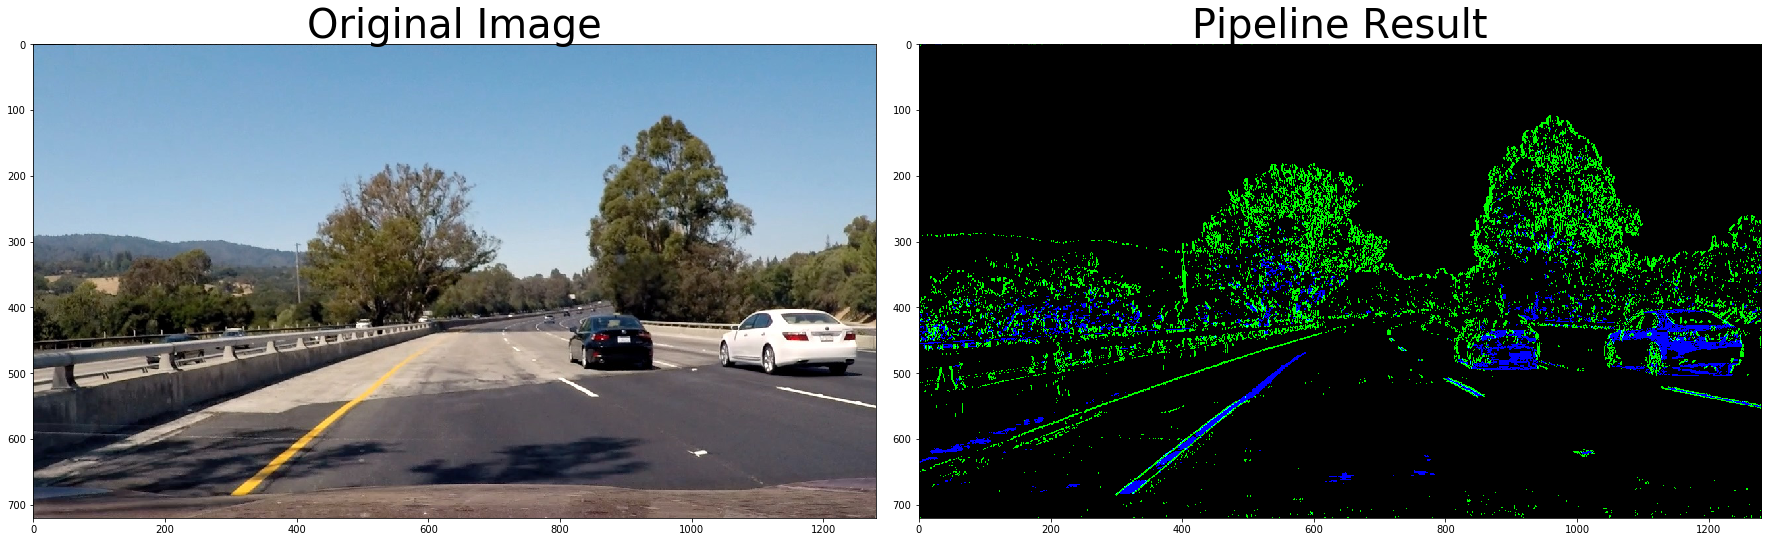

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread('bridge_shadow.jpg')


# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):

    #     ## !! LINE BELOW :: HOW DOES DEEP COPYING TO ITSELF HELP ??!!
    #     ## WHAT AM I MISSING HERE ?
    #     img = np.copy(img)
    #
    #     # SHOULD IT NOT BE: ??
    #     img_copy = np.copy(img) 
    #
    #     # IN Fact, does Not Python Pass by COPY Always ??
    #     # So np.copy() is NOT Needed At All??
    #
    #     # Indeed: If I remove that line, 
    #     # "Original Image" plots the orig image, as Expected !
    #    
    # -SH

    img = np.copy(img)
    
    ## HUH? BELOW: 
    ##
    ## Why is HLS conversion being labeled as an HSV conversion ??
    #
    # hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    # 
    ## -SH
         
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)